In [13]:
# Core libraries
import pandas as pd
import numpy as np
import re

# NLP
import nltk
from nltk.corpus import stopwords

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Saving the model
import joblib

# Download NLTK resources (run once)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# ============================
# 📌 CELL 2: Load Kaggle Dataset
# ============================

# Path to the CSV file you uploaded in Colab
DATA_PATH = "/content/IMDB Dataset.csv"  # <= لو اسم ملفك مختلف عدّليه هنا فقط

import pandas as pd
from csv import QUOTE_NONE

# Try loading with protection from broken quotes/columns
df = pd.read_csv(
    DATA_PATH,
    encoding="utf-8",
    on_bad_lines="skip",   # تخطي الأسطر اللي فيها مشاكل
    quoting=QUOTE_NONE      # منع تخريب الأعمدة بسبب الاقتباسات
)

# عرض أول 5 صفوف والتأكد من شكل البيانات
print("Shape:", df.shape)
print(df.head())
print("\nColumns:", df.columns, "\n")

# ----------------------------
# 📍 توحيد أسماء الأعمدة لو ما كانت مرتبة
# البيانات الصحيحة المفروض يكون فيها:
# review = النص | sentiment = التصنيف
# ----------------------------

# إذا كانت الأعمدة مختلفة بيرجعها للأسماء الصحيحة
if "review" not in df.columns or "sentiment" not in df.columns:
    df = df.rename(columns={
        df.columns[0]: "review",
        df.columns[-1]: "sentiment"
    })

# تأكيد وجود الأعمدة بعد التعديل
print("Final Columns:", df.columns, "\n")
print(df[["review", "sentiment"]].head())



Shape: (23181, 12)
  o people ""wouldn't"" think about checking things out. This documentary is a total failure  \
0  "There was nothing else on tv yesterday afternoon                                           
1  "Tony Curtis and Skip Homier both are wearing ...                                           
2  "You may be interested to know that BARRICADE ...                                           
3  "I own this movie. I bought it for $3.99 at a ...                                           
4        "The famous closeup of their breakfast meat                                           

   how stupid they think the Christian people are? And what about the Lost pages of Judas... that was a total scam as well  \
0                                so I thought ""okay                                                                         
1   then later when Lovejoy and Curtis run into t...                                                                         
2   it is entirely missing

In [23]:
# Build English stopwords set
stop_words = set(stopwords.words("english"))

# Keep negation words because they flip meaning
negation_words = {
    "no", "not", "nor", "don't", "didn't", "isn't", "wasn't",
    "can't", "couldn't", "won't", "shouldn't", "wouldn't"
}
stop_words = stop_words - negation_words


def clean_text(text: str) -> str:
    """
    Clean raw review text:
    - Lowercase
    - Remove HTML tags
    - Remove URLs
    - Remove non-letter characters
    - Remove extra spaces
    - Remove stopwords (but keep negations)
    """
    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Remove HTML tags like <br />
    text = re.sub(r"<.*?>", " ", text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)

    # Keep only letters and spaces
    text = re.sub(r"[^a-z\s]", " ", text)

    # Split into tokens
    tokens = text.split()

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Join back to string
    return " ".join(tokens)


# Apply cleaning
df["clean_review"] = df["review"].apply(clean_text)

df[["review", "clean_review", "sentiment"]].head()


,review,clean_review,sentiment
0,"""There was nothing else on tv yesterday afternoon",nothing else tv yesterday afternoon,NaN
1,"""Tony Curtis and Skip Homier both are wearing ...",tony curtis skip homier wearing black white tr...,NaN
2,"""You may be interested to know that BARRICADE ...",may interested know barricade viewed failure s...,NaN
3,"""I own this movie. I bought it for $3.99 at a ...",movie bought fairly major video retailer order...,NaN
4,"""The famous closeup of their breakfast meat",famous closeup breakfast meat,NaN


In [29]:
# ============================
# 📌 CELL 5: Prepare data and train/test split
# ============================

# نتأكد أننا نشتغل فقط على الأعمدة اللي نحتاجها
# ونحذف أي صف فيه NaN في review أو sentiment أو clean_review
df_model = df[["clean_review", "sentiment"]].dropna()

print("Shape after dropping NaN:", df_model.shape)
print(df_model.head())

# X: النصوص المنظّفة, y: الليبلات
X_text = df_model["clean_review"].values
y = df_model["sentiment"].values

from sklearn.model_selection import train_test_split

# Train/test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train_text))
print("Test size:", len(X_test_text))


Shape after dropping NaN: (1684, 2)
                                         clean_review sentiment
19          someone staggered incredible visuals hero  negative
22                                              sadly  positive
24  thought long lost flick sometimes comes availa...  negative
29      stuff going moment mj started listening music  positive
57                                             reason  negative
Train size: 1347
Test size: 337


In [30]:
# Convert text to numeric features using TF-IDF
vectorizer = TfidfVectorizer(
    max_features=20000,      # limit vocabulary size
    ngram_range=(1, 2),      # unigrams + bigrams
    min_df=5,                # ignore very rare tokens
    max_df=0.8               # ignore very frequent tokens
)

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Build and train the model
model = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))


X_train shape: (1347, 616)
X_test shape: (337, 616)
Accuracy: 0.6499

Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.72      0.68       177
    positive       0.65      0.57      0.61       160

    accuracy                           0.65       337
   macro avg       0.65      0.65      0.65       337
weighted avg       0.65      0.65      0.65       337



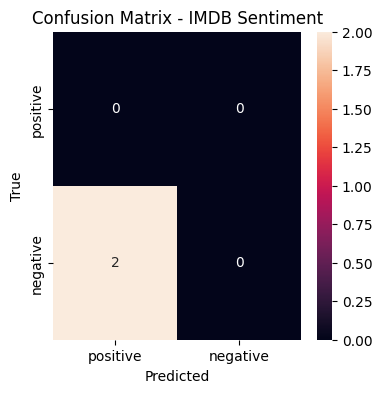

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])

plt.figure(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=["positive", "negative"],
    yticklabels=["positive", "negative"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - IMDB Sentiment")
plt.show()


In [34]:
# Paths for saving model and vectorizer
MODEL_PATH = "/content/imdb_sentiment_model.pkl"
VECTORIZER_PATH = "/content/imdb_tfidf_vectorizer.pkl"

joblib.dump(model, MODEL_PATH)
joblib.dump(vectorizer, VECTORIZER_PATH)

print("Saved model to:", MODEL_PATH)
print("Saved vectorizer to:", VECTORIZER_PATH)


Saved model to: /content/imdb_sentiment_model.pkl
Saved vectorizer to: /content/imdb_tfidf_vectorizer.pkl


In [33]:
# ============================
# 📌 Final Testing Cell
# ============================

test_reviews = [
    "I absolutely loved this movie, it was emotional and brilliant.",
    "This was a boring film, I regret watching it.",
    "I did not like this movie at all, terrible acting."
]

for review in test_reviews:
    print(review, " => ", predict_sentiment(review))


I absolutely loved this movie, it was emotional and brilliant.  =>  positive
This was a boring film, I regret watching it.  =>  negative
I did not like this movie at all, terrible acting.  =>  negative
